### Import Libraries


In [1]:
import pathlib
import pandas as pd
from joblib import load

import sys

sys.path.append("../utils")
from split_utils import get_features_data
from train_utils import get_dataset
from single_cell_utils import (
    get_15_correct_sample_images,
    plot_15_correct_sample_images,
)

### Load CP_and_DP Multi-class Model and Test Dataset


In [2]:
# load final logistic regression model
models_dir = pathlib.Path("../2.train_model/models/multi_class_models/")
log_reg_model_path = pathlib.Path(f"{models_dir}/final__CP_and_DP.joblib")
log_reg_model = load(log_reg_model_path)

# load test data
data_split_path = pathlib.Path("../1.split_data/indexes/data_split_indexes.tsv")
data_split_indexes = pd.read_csv(data_split_path, sep="\t", index_col=0)
features_dataframe_path = pathlib.Path("../0.download_data/data/labeled_data.csv.gz")
features_dataframe = get_features_data(features_dataframe_path)
test_data = get_dataset(features_dataframe, data_split_indexes, "test")


### Get 5 best performing classes (final model, test dataset)


In [3]:
# load compiled f1 scores
compiled_f1_scores_path = pathlib.Path(
    "../3.evaluate_model/evaluations/F1_scores/compiled_F1_scores.tsv"
)
compiled_f1_scores = pd.read_csv(compiled_f1_scores_path, sep="\t", index_col=0)

# only get f1 score data for CP_and_DP final model on test data
final_model_test_f1_scores = compiled_f1_scores.loc[
    (compiled_f1_scores["shuffled"] == False)
    & (compiled_f1_scores["data_split"] == "test")
    & (compiled_f1_scores["feature_type"] == "CP_and_DP")
]
# sort the F1 score data highest to lowest
final_model_test_f1_scores = final_model_test_f1_scores.sort_values(
    ["F1_Score"], ascending=False
)
# only use top 5 performing phenotypes
final_model_test_f1_scores = final_model_test_f1_scores.head(5)
# preview phenotypic classes and F1 scores
final_model_test_f1_scores

,Phenotypic_Class,F1_Score,data_split,shuffled,feature_type
59,OutOfFocus,0.989011,test,False,CP_and_DP
52,Elongated,0.937500,test,False,CP_and_DP
49,Anaphase,0.928571,test,False,CP_and_DP
50,Apoptosis,0.915663,test,False,CP_and_DP
62,SmallIrregular,0.905660,test,False,CP_and_DP


### Get 15 correct sample images (3 from each of the 5 top performing classes) and save their paths


In [4]:
single_cell_images_dir_path = pathlib.Path("mitocheck_single_cell_sample_images/")
phenotypic_classes = final_model_test_f1_scores["Phenotypic_Class"].tolist()
correct_15_images = get_15_correct_sample_images(
    phenotypic_classes, test_data, log_reg_model, single_cell_images_dir_path, feature_type="CP_and_DP"
)

# save paths of 15 images in tidy format
# use melt to convert pandas dataframe to tidy long format and drop/rename to achieve desired format
tidy_15_images = (
    pd.melt(correct_15_images, ["Phenotypic_Class"], ignore_index=True)
    .sort_values(["Phenotypic_Class"])
    .reset_index(drop=True)
)
tidy_15_images = tidy_15_images.drop(["variable"], axis=1)
tidy_15_images = tidy_15_images.rename(columns={"value": "Correctly_Labled_Image_Path"})

tidy_15_images_save_path = pathlib.Path(
    "sample_image_paths/top_5_performing_classes.tsv"
)
tidy_15_images_save_path.parents[0].mkdir(parents=True, exist_ok=True)
tidy_15_images.to_csv(tidy_15_images_save_path, sep="\t")

# show the 15 image paths that are being used
correct_15_images


,Phenotypic_Class,Path_0,Path_1,Path_2
0,OutOfFocus,mitocheck_single_cell_sample_images/OutOfFocus...,mitocheck_single_cell_sample_images/OutOfFocus...,mitocheck_single_cell_sample_images/OutOfFocus...
1,Elongated,mitocheck_single_cell_sample_images/Elongated/...,mitocheck_single_cell_sample_images/Elongated/...,mitocheck_single_cell_sample_images/Elongated/...
2,Anaphase,mitocheck_single_cell_sample_images/Anaphase/P...,mitocheck_single_cell_sample_images/Anaphase/P...,mitocheck_single_cell_sample_images/Anaphase/P...
3,Apoptosis,mitocheck_single_cell_sample_images/Apoptosis/...,mitocheck_single_cell_sample_images/Apoptosis/...,mitocheck_single_cell_sample_images/Apoptosis/...
4,SmallIrregular,mitocheck_single_cell_sample_images/SmallIrreg...,mitocheck_single_cell_sample_images/SmallIrreg...,mitocheck_single_cell_sample_images/SmallIrreg...


### Show 3 examples of correct predictions for each of top 5 performing phenotypic classes


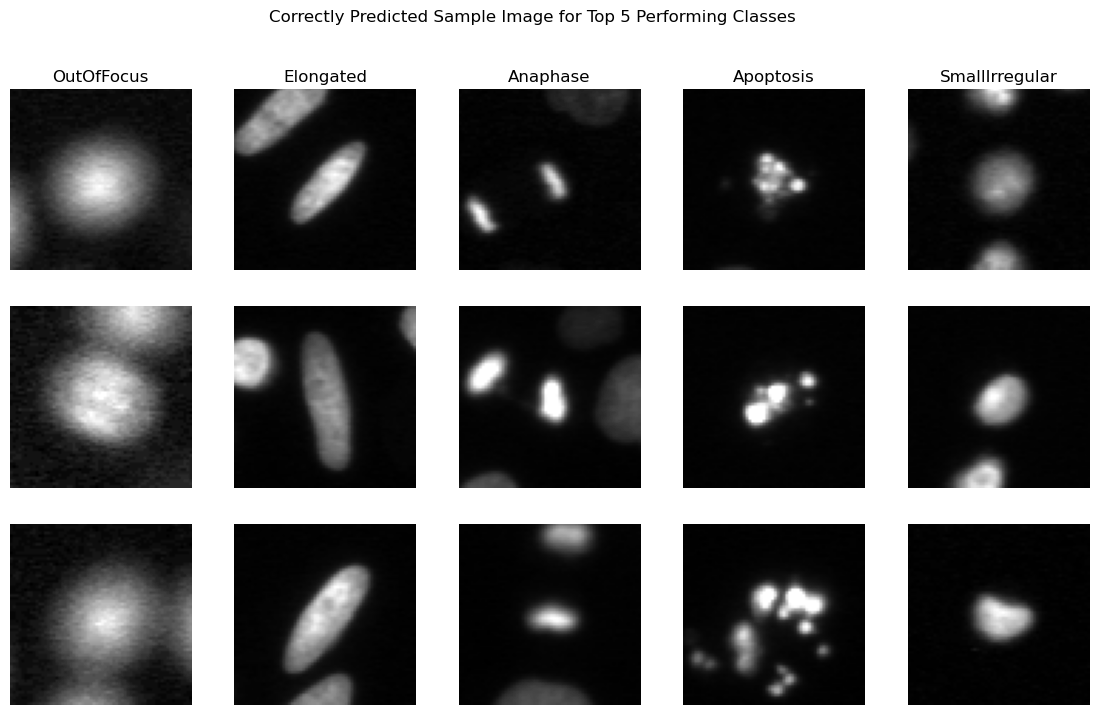

In [5]:
plot_15_correct_sample_images(correct_15_images)
